In [1]:
# Customer Segmentation and Product Analysis for UK Gift Retail
# Advanced Data Mining Project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Data Loading and Initial Exploration

# Load the retail dataset from the data directory
data_path = '../data/reduced_retail.csv'
df = pd.read_csv(data_path, encoding='latin1')

# Basic dataset information
df.shape

(9735, 8)

In [3]:
# Display dataframe structure
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26,3.39,17850.0,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9735 entries, 0 to 9734
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    9735 non-null   object 
 1   StockCode    9735 non-null   object 
 2   Description  9693 non-null   object 
 3   Quantity     9735 non-null   int64  
 4   InvoiceDate  9735 non-null   object 
 5   UnitPrice    9735 non-null   float64
 6   CustomerID   7445 non-null   float64
 7   Country      9735 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 608.6+ KB


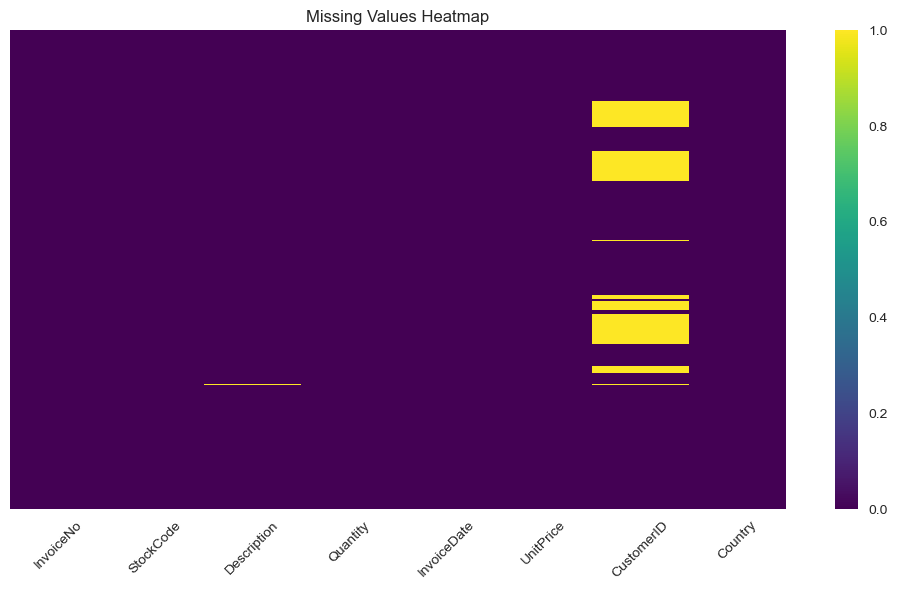

In [4]:
# Check data types and missing values
df.info()
df.isnull().sum()

# Heatmap to visualize null values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=True, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Data Cleaning
# Fix column names (remove BOM if present)
df.columns = df.columns.str.replace('ï»¿', '', regex=False)

# Convert CustomerID to object datatype
df['CustomerID'] = df['CustomerID'].astype('object')

# Remove null values in CustomerID and Description
df_clean = df.dropna(subset=['CustomerID', 'Description']).copy()

# Remove duplicates
df_clean = df_clean.drop_duplicates()

# Filter out cancellations (invoices starting with 'C') - use ~ to negate
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative or zero quantities
df_clean = df_clean[df_clean['Quantity'] > 0]

# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Calculate TotalPrice
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Update main dataframe
df = df_clean.copy()

# Display final shape
df.shape
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [6]:
# 3. EXPLORATORY DATA ANALYSIS
print("3. EXPLORATORY DATA ANALYSIS")

# Country distribution
print("Top 10 countries by transaction volume:")
country_stats = df['Country'].value_counts().head(10)
print(country_stats)

# Create visualizations
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Top Countries', 'Top Products', 'Price Distribution'),
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "histogram"}, {"type": "scatter"}]]
)

# Top countries
fig.add_trace(
    go.Bar(x=country_stats.head(10).index, y=country_stats.head(10).values, name="Countries"),
    row=1, col=1
)


# Top products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
fig.add_trace(
    go.Bar(x=top_products.values, y=top_products.index, orientation='h', name="Top Products"),
    row=2, col=1
)

# Price distribution
fig.add_trace(
    go.Histogram(x=df[df['UnitPrice'] < 50]['UnitPrice'], nbinsx=50, name="Price Distribution"),
    row=1, col=2
)

fig.update_layout(height=800, showlegend=False, title_text="Exploratory Data Analysis Dashboard")
fig.show()

print("Key Statistics:")
print(f"Average order value: £{df['TotalPrice'].mean():.2f}")
print(f"Median order value: £{df['TotalPrice'].median():.2f}")
print(f"Total revenue: £{df['TotalPrice'].sum():,.2f}")
print(f"Average items per transaction: {df['Quantity'].mean():.2f}")

3. EXPLORATORY DATA ANALYSIS
Top 10 countries by transaction volume:
Country
United Kingdom    6604
Germany            166
France             106
EIRE                96
Norway              73
Lithuania           34
Italy               24
Australia           14
Belgium             12
Poland               8
Name: count, dtype: int64


Key Statistics:
Average order value: £19.97
Median order value: £10.20
Total revenue: £142,920.54
Average items per transaction: 11.08


In [7]:
# 4. RFM SEGMENTATION (LOYALTY IDENTIFICATION)
print("4. RFM SEGMENTATION")

# Calculate RFM metrics
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Analysis snapshot date: {snapshot_date}")

# Aggregate by customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency', 
    'TotalPrice': 'Monetary'
})

print(f"RFM calculated for {len(rfm)} customers")
print("RFM Statistics:")
print(rfm.describe())

# Calculate RFM scores using rank-based approach
rfm_scores = rfm.copy()

# Create score functions using rank and scaling to 1-4
def score_rfm(series, ascending=True):
    """Convert series to scores 1-4 based on rank"""
    ranks = series.rank(ascending=ascending, method='first')
    # Scale ranks to 1-4 range
    scores = pd.cut(ranks, bins=4, labels=[1,2,3,4], include_lowest=True)
    return scores.astype(int)

# Recency: Lower is better (more recent), so use ascending=True for scoring
rfm_scores['R_Score'] = score_rfm(rfm_scores['Recency'], ascending=True)

# Frequency and Monetary: Higher is better, so use ascending=False for scoring  
rfm_scores['F_Score'] = score_rfm(rfm_scores['Frequency'], ascending=False)
rfm_scores['M_Score'] = score_rfm(rfm_scores['Monetary'], ascending=False)

# For recency, we want to reverse the scores so lower recency gets higher score
rfm_scores['R_Score'] = 5 - rfm_scores['R_Score']

# Combine RFM scores
rfm_scores['RFM_Score'] = rfm_scores['R_Score']*100 + rfm_scores['F_Score']*10 + rfm_scores['M_Score']

# Define loyalty based on threshold (>=222 as per methodology)
rfm_scores['Loyal'] = (rfm_scores['RFM_Score'] >= 222).astype(int)

print("Loyalty Distribution:")
loyalty_dist = rfm_scores['Loyal'].value_counts(normalize=True)
print(f"Not Loyal (0): {loyalty_dist[0]:.1%}")
print(f"Loyal (1): {loyalty_dist[1]:.1%}")

print(f"Number of loyal customers: {rfm_scores['Loyal'].sum():,}")
print(f"Percentage of loyal customers: {rfm_scores['Loyal'].mean():.1%}")

# Display sample RFM scores
print("Sample RFM Scores:")
print(rfm_scores.head(10))

4. RFM SEGMENTATION
Analysis snapshot date: 2010-12-06 15:21:00
RFM calculated for 294 customers
RFM Statistics:
          Recency   Frequency     Monetary
count  294.000000  294.000000   294.000000
mean     3.241497    1.326531   486.124286
std      1.428445    2.032713   837.513371
min      1.000000    1.000000    15.000000
25%      3.000000    1.000000   187.772500
50%      3.000000    1.000000   297.010000
75%      4.000000    1.000000   430.300000
max      5.000000   34.000000  9407.340000
Loyalty Distribution:
Not Loyal (0): 31.3%
Loyal (1): 68.7%
Number of loyal customers: 202
Percentage of loyal customers: 68.7%
Sample RFM Scores:
            Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
CustomerID                                                            
12395.0           2          1    346.10        4        1        2   
12427.0           3          1    303.50        4        1        2   
12431.0           5          1    358.25        1        1        2  

In [8]:
# RFM Visualization
print("RFM Analysis Visualizations:")

# Create RFM scatter plot
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('RFM Scatter (Frequency vs Recency)', 'RFM Distribution', 'Monetary Distribution by Loyalty', 'RFM Score Distribution')
)

# Scatter plot: Frequency vs Recency colored by Loyalty
loyal_customers = rfm_scores[rfm_scores['Loyal'] == 1]
non_loyal_customers = rfm_scores[rfm_scores['Loyal'] == 0]

fig.add_trace(
    go.Scatter(
        x=non_loyal_customers['Recency'], 
        y=non_loyal_customers['Frequency'],
        mode='markers',
        name='Not Loyal',
        marker=dict(color='lightcoral', size=4, opacity=0.6)
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=loyal_customers['Recency'], 
        y=loyal_customers['Frequency'],
        mode='markers',
        name='Loyal',
        marker=dict(color='darkgreen', size=6, opacity=0.8)
    ), row=1, col=1
)

# RFM individual distributions
fig.add_trace(
    go.Box(y=rfm_scores['Recency'], name='Recency', boxpoints='outliers'),
    row=1, col=2
)

# Monetary distribution by loyalty
fig.add_trace(
    go.Histogram(x=non_loyal_customers['Monetary'], name='Not Loyal (Monetary)', opacity=0.7, nbinsx=30),
    row=2, col=1
)
fig.add_trace(
    go.Histogram(x=loyal_customers['Monetary'], name='Loyal (Monetary)', opacity=0.7, nbinsx=30),
    row=2, col=1
)

# RFM Score distribution
fig.add_trace(
    go.Histogram(x=rfm_scores['RFM_Score'], name='RFM Score', nbinsx=50),
    row=2, col=2
)

fig.update_layout(height=800, title_text="RFM Analysis Dashboard")
fig.update_xaxes(title_text="Recency (Days)", row=1, col=1)
fig.update_yaxes(title_text="Frequency (Transactions)", row=1, col=1)
fig.update_xaxes(title_text="Monetary Value (£)", row=2, col=1)
fig.update_xaxes(title_text="RFM Score", row=2, col=2)

fig.show()

print("Key RFM Insights:")
print(f"Average recency for loyal customers: {loyal_customers['Recency'].mean():.1f} days")
print(f"Average recency for non-loyal customers: {non_loyal_customers['Recency'].mean():.1f} days")
print(f"Average frequency for loyal customers: {loyal_customers['Frequency'].mean():.1f} transactions")
print(f"Average frequency for non-loyal customers: {non_loyal_customers['Frequency'].mean():.1f} transactions")
print(f"Average monetary for loyal customers: £{loyal_customers['Monetary'].mean():.2f}")
print(f"Average monetary for non-loyal customers: £{non_loyal_customers['Monetary'].mean():.2f}")

RFM Analysis Visualizations:


Key RFM Insights:
Average recency for loyal customers: 2.6 days
Average recency for non-loyal customers: 4.7 days
Average frequency for loyal customers: 1.4 transactions
Average frequency for non-loyal customers: 1.2 transactions
Average monetary for loyal customers: £496.62
Average monetary for non-loyal customers: £463.09


In [9]:
features = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(features)

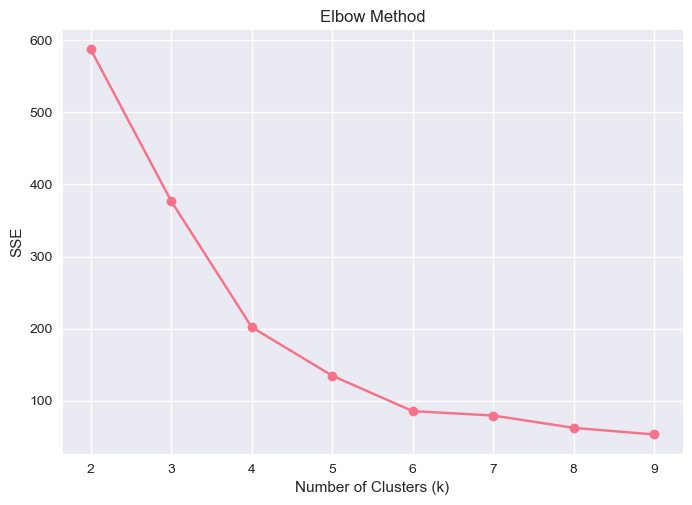

In [10]:
sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 10), sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [11]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_scores['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [12]:
# DBSCAN Clustering Analysis
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Find optimal epsilon using k-distance graph
k = 4  # MinPts = k = 4 (common choice)
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)
distances = np.sort(distances[:, k-1], axis=0)

# Apply DBSCAN with different epsilon values
eps_values = [0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
dbscan_results = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=4)
    dbscan_labels = dbscan.fit_predict(rfm_scaled)
    
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    if n_clusters > 0:
        from sklearn.metrics import silhouette_score
        silhouette_avg = silhouette_score(rfm_scaled, dbscan_labels) if n_clusters > 1 else 0
    else:
        silhouette_avg = -1
    
    dbscan_results.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette': silhouette_avg
    })

# Select optimal epsilon
dbscan_df = pd.DataFrame(dbscan_results)
optimal_eps = dbscan_df.loc[dbscan_df['silhouette'].idxmax(), 'eps']

# Apply optimal DBSCAN
dbscan_optimal = DBSCAN(eps=optimal_eps, min_samples=4)
rfm_scores['DBSCAN_Cluster'] = dbscan_optimal.fit_predict(rfm_scaled)

# Create comprehensive comparison visualization
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        'K-Means Clusters (3D)', 'DBSCAN Clusters (3D)',
        'Epsilon Parameter Tuning', 'Cluster Comparison',
        'Silhouette Analysis', 'Noise Detection (DBSCAN)'
    ),
    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}],
           [{"type": "scatter"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "scatter"}]]
)

# K-Means 3D visualization
kmeans_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for i in range(4):
    cluster_mask = rfm_scores['Cluster'] == i
    cluster_data = rfm_scores[cluster_mask]
    
    fig.add_trace(
        go.Scatter3d(
            x=cluster_data['Recency'],
            y=cluster_data['Frequency'],
            z=cluster_data['Monetary'],
            mode='markers',
            marker=dict(size=4, color=kmeans_colors[i], opacity=0.7),
            name=f'K-Means {i}',
            legendgroup='kmeans'
        ),
        row=1, col=1
    )

# DBSCAN 3D visualization
dbscan_clusters = sorted(rfm_scores['DBSCAN_Cluster'].unique())
dbscan_colors = ['#FF1744', '#00E676', '#2196F3', '#FF9800', '#9C27B0', '#4CAF50', '#FFC107']

for i, cluster in enumerate(dbscan_clusters):
    cluster_mask = rfm_scores['DBSCAN_Cluster'] == cluster
    cluster_data = rfm_scores[cluster_mask]
    
    color = '#000000' if cluster == -1 else dbscan_colors[i % len(dbscan_colors)]
    name = 'Noise' if cluster == -1 else f'DBSCAN {cluster}'
    
    fig.add_trace(
        go.Scatter3d(
            x=cluster_data['Recency'],
            y=cluster_data['Frequency'],
            z=cluster_data['Monetary'],
            mode='markers',
            marker=dict(size=4, color=color, opacity=0.7),
            name=name,
            legendgroup='dbscan'
        ),
        row=1, col=2
    )

# Epsilon parameter tuning
fig.add_trace(
    go.Scatter(
        x=dbscan_df['eps'],
        y=dbscan_df['silhouette'],
        mode='lines+markers',
        name='Silhouette Score',
        line=dict(color='blue'),
        showlegend=False
    ),
    row=2, col=1
)

# Add annotation for optimal eps instead of vertical line
fig.add_annotation(
    x=optimal_eps,
    y=dbscan_df.loc[dbscan_df['eps'] == optimal_eps, 'silhouette'].iloc[0],
    text=f"Optimal ε={optimal_eps}",
    showarrow=True,
    arrowhead=2,
    arrowcolor="red",
    ax=20,
    ay=-30,
    row=2, col=1
)

# Cluster comparison
methods = ['K-Means', 'DBSCAN']
cluster_counts = [4, len([x for x in dbscan_clusters if x != -1])]
noise_counts = [0, list(rfm_scores['DBSCAN_Cluster']).count(-1)]

fig.add_trace(
    go.Bar(x=methods, y=cluster_counts, name='Clusters', marker_color='lightblue', showlegend=False),
    row=2, col=2
)

# Silhouette comparison
from sklearn.metrics import silhouette_score
kmeans_silhouette = silhouette_score(rfm_scaled, rfm_scores['Cluster'])
dbscan_silhouette = silhouette_score(rfm_scaled, rfm_scores['DBSCAN_Cluster']) if len(set(rfm_scores['DBSCAN_Cluster'])) > 1 else 0

fig.add_trace(
    go.Bar(
        x=['K-Means', 'DBSCAN'],
        y=[kmeans_silhouette, dbscan_silhouette],
        marker_color=['lightcoral', 'lightgreen'],
        name='Silhouette Score',
        showlegend=False
    ),
    row=3, col=1
)

# Noise detection scatter
noise_data = rfm_scores[rfm_scores['DBSCAN_Cluster'] == -1]
normal_data = rfm_scores[rfm_scores['DBSCAN_Cluster'] != -1]

fig.add_trace(
    go.Scatter(
        x=normal_data['Frequency'],
        y=normal_data['Monetary'],
        mode='markers',
        marker=dict(color='lightblue', size=4, opacity=0.6),
        name='Normal Points',
        showlegend=False
    ),
    row=3, col=2
)

fig.add_trace(
    go.Scatter(
        x=noise_data['Frequency'],
        y=noise_data['Monetary'],
        mode='markers',
        marker=dict(color='red', size=6, opacity=0.8),
        name='Noise/Outliers',
        showlegend=False
    ),
    row=3, col=2
)

# Update layout
fig.update_layout(
    height=1200,
    title_text="K-Means vs DBSCAN Clustering Comparison",
    showlegend=True
)

# Update axes labels
fig.update_scenes(
    xaxis_title="Recency (Days)",
    yaxis_title="Frequency (Transactions)",
    zaxis_title="Monetary (£)"
)

fig.update_xaxes(title_text="Epsilon", row=2, col=1)
fig.update_yaxes(title_text="Silhouette Score", row=2, col=1)
fig.update_xaxes(title_text="Method", row=2, col=2)
fig.update_yaxes(title_text="Number of Clusters", row=2, col=2)
fig.update_xaxes(title_text="Method", row=3, col=1)
fig.update_yaxes(title_text="Silhouette Score", row=3, col=1)
fig.update_xaxes(title_text="Frequency (Transactions)", row=3, col=2)
fig.update_yaxes(title_text="Monetary (£)", row=3, col=2)

fig.show()

# DBSCAN cluster analysis
dbscan_analysis = pd.DataFrame()

for cluster_id in sorted(rfm_scores['DBSCAN_Cluster'].unique()):
    cluster_data = rfm_scores[rfm_scores['DBSCAN_Cluster'] == cluster_id]
    
    analysis = {
        'Cluster': cluster_id,
        'Size': len(cluster_data),
        'Size_Percentage': len(cluster_data) / len(rfm_scores) * 100,
        'Avg_Recency': cluster_data['Recency'].mean(),
        'Avg_Frequency': cluster_data['Frequency'].mean(),
        'Avg_Monetary': cluster_data['Monetary'].mean(),
        'Loyalty_Rate': cluster_data['Loyal'].mean() * 100
    }
    
    dbscan_analysis = pd.concat([dbscan_analysis, pd.DataFrame([analysis])], ignore_index=True)

# Comparison summary
comparison_summary = pd.DataFrame({
    'Method': ['K-Means', 'DBSCAN'],
    'Number_of_Clusters': [4, len([x for x in dbscan_clusters if x != -1])],
    'Noise_Points': [0, list(rfm_scores['DBSCAN_Cluster']).count(-1)],
    'Silhouette_Score': [kmeans_silhouette, dbscan_silhouette],
    'Optimal_Parameter': [f'k=4', f'eps={optimal_eps}']
}).round(3)

display(comparison_summary)
display(dbscan_analysis.round(2))

# Key insights
total_noise = list(rfm_scores['DBSCAN_Cluster']).count(-1)
noise_percentage = (total_noise / len(rfm_scores)) * 100

insights = f"""
CLUSTERING COMPARISON INSIGHTS:

K-MEANS vs DBSCAN ANALYSIS:
- K-Means identified 4 predefined clusters with silhouette score: {kmeans_silhouette:.3f}
- DBSCAN identified {len([x for x in dbscan_clusters if x != -1])} clusters with silhouette score: {dbscan_silhouette:.3f}
- DBSCAN detected {total_noise} noise points ({noise_percentage:.1f}% of data)
- Optimal epsilon for DBSCAN: {optimal_eps}

ALGORITHM STRENGTHS:
K-Means: Consistent cluster sizes, good for well-separated spherical clusters
DBSCAN: Identifies outliers, handles irregular cluster shapes, no predefined cluster count

BUSINESS IMPLICATIONS:
- Noise points in DBSCAN represent unusual customer behavior patterns
- DBSCAN clusters may reveal natural customer groupings
- K-Means provides more balanced segments for marketing campaigns
"""

display(insights)

,Method,Number_of_Clusters,Noise_Points,Silhouette_Score,Optimal_Parameter
0,K-Means,4,0,0.485,k=4
1,DBSCAN,6,21,0.550,eps=0.5


,Cluster,Size,Size_Percentage,Avg_Recency,Avg_Frequency,Avg_Monetary,Loyalty_Rate
0,-1,21,7.14,2.71,4.24,2503.28,80.95
1,0,6,2.04,2.00,1.17,251.86,100.00
2,1,63,21.43,3.00,1.05,266.24,100.00
3,2,64,21.77,5.00,1.09,322.10,0.00
4,3,60,20.41,1.00,1.12,326.33,100.00
5,4,75,25.51,4.00,1.15,317.24,68.00
6,5,5,1.70,3.00,1.00,1615.99,100.00


'\nCLUSTERING COMPARISON INSIGHTS:\n\nK-MEANS vs DBSCAN ANALYSIS:\n- K-Means identified 4 predefined clusters with silhouette score: 0.485\n- DBSCAN identified 6 clusters with silhouette score: 0.550\n- DBSCAN detected 21 noise points (7.1% of data)\n- Optimal epsilon for DBSCAN: 0.5\n\nALGORITHM STRENGTHS:\nK-Means: Consistent cluster sizes, good for well-separated spherical clusters\nDBSCAN: Identifies outliers, handles irregular cluster shapes, no predefined cluster count\n\nBUSINESS IMPLICATIONS:\n- Noise points in DBSCAN represent unusual customer behavior patterns\n- DBSCAN clusters may reveal natural customer groupings\n- K-Means provides more balanced segments for marketing campaigns\n'

In [13]:
# Add DBSCAN cluster labels to main dataframe
df = df.merge(
    rfm_scores[['DBSCAN_Cluster']], 
    left_on='CustomerID', 
    right_index=True, 
    how='left'
)

# Verify the merge
df['DBSCAN_Cluster'].value_counts().sort_index()

DBSCAN_Cluster
-1    1270
 0     114
 1    1218
 2    1218
 3    1956
 4    1324
 5      57
Name: count, dtype: int64

In [14]:
# Association Rule Mining using FP-Growth
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import gc

# Optimize data preparation for better performance
def create_optimized_basket(df, min_transaction_size=2):
    # Filter out single-item transactions to reduce noise
    transaction_sizes = df.groupby('InvoiceNo').size()
    valid_invoices = transaction_sizes[transaction_sizes >= min_transaction_size].index
    
    # Filter data to include only valid invoices
    filtered_df = df[df['InvoiceNo'].isin(valid_invoices)]
    
    # Create transactions list more efficiently
    transactions = []
    for invoice, group in filtered_df.groupby('InvoiceNo'):
        # Limit to top items to reduce memory usage
        items = group['Description'].str.strip().str.upper().tolist()[:20]
        if len(items) >= min_transaction_size:
            transactions.append(items)
    
    # Use TransactionEncoder for binary encoding
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    
    # Create DataFrame with optimized memory usage
    basket = pd.DataFrame(te_ary, columns=te.columns_, dtype='bool')
    
    # Filter out items with very low frequency to improve performance
    item_frequencies = basket.sum()
    min_frequency = max(10, len(basket) * 0.005)  # At least 10 transactions or 0.5% of data
    frequent_items = item_frequencies[item_frequencies >= min_frequency].index
    basket = basket[frequent_items]
    
    return basket

# Create market basket with optimization
basket_data = create_optimized_basket(df)

# Find frequent itemsets using FP-Growth with optimized parameters
frequent_itemsets = fpgrowth(
    basket_data, 
    min_support=0.02,  # Increased min_support for better performance
    use_colnames=True,
    max_len=3  # Limit max itemset length to improve performance
)

if len(frequent_itemsets) > 0:
    # Generate association rules with higher confidence threshold
    rules = association_rules(
        frequent_itemsets, 
        metric="confidence", 
        min_threshold=0.2,  # Higher threshold for better quality rules
        num_itemsets=len(frequent_itemsets)
    )
    
    if len(rules) > 0:
        # Sort rules by lift and confidence for best rules first
        rules = rules.sort_values(['lift', 'confidence'], ascending=False)
        
        # Display top association rules
        top_rules = rules.head(20)
        
        # Create results summary
        results_summary = pd.DataFrame({
            'Antecedent': [', '.join(list(rule['antecedents'])) for _, rule in top_rules.iterrows()],
            'Consequent': [', '.join(list(rule['consequents'])) for _, rule in top_rules.iterrows()],
            'Support': top_rules['support'].round(4),
            'Confidence': top_rules['confidence'].round(4),
            'Lift': top_rules['lift'].round(4)
        })
        
        # Comprehensive rule quality evaluation
        rules['conviction'] = (1 - rules['consequent support']) / (1 - rules['confidence'])
        rules['leverage'] = rules['support'] - (rules['antecedent support'] * rules['consequent support'])
        rules['zhang_metric'] = rules['leverage'] / np.maximum(
            rules['support'] * (1 - rules['consequent support']),
            rules['consequent support'] * (1 - rules['support'])
        )
        
        # Quality classification
        def classify_rule_quality(row):
            if row['lift'] > 2 and row['confidence'] > 0.7:
                return 'Excellent'
            elif row['lift'] > 1.5 and row['confidence'] > 0.5:
                return 'Good'
            elif row['lift'] > 1.2 and row['confidence'] > 0.3:
                return 'Fair'
            else:
                return 'Poor'
        
        rules['quality_class'] = rules.apply(classify_rule_quality, axis=1)
        
        # Quality distribution
        quality_counts = rules['quality_class'].value_counts()
        
        # Enhanced results summary with quality metrics
        results_summary = pd.DataFrame({
            'Antecedent': [', '.join(list(rule['antecedents'])) for _, rule in top_rules.iterrows()],
            'Consequent': [', '.join(list(rule['consequents'])) for _, rule in top_rules.iterrows()],
            'Support': top_rules['support'].round(4),
            'Confidence': top_rules['confidence'].round(4),
            'Lift': top_rules['lift'].round(4),
            'Conviction': top_rules['conviction'].round(4),
            'Leverage': top_rules['leverage'].round(4),
            'Quality': [classify_rule_quality(rule) for _, rule in top_rules.iterrows()]
        })
        
        # Analysis statistics with quality metrics
        analysis_stats = {
            'Total_Transactions': len(basket_data),
            'Total_Unique_Items': len(basket_data.columns),
            'Total_Frequent_Itemsets': len(frequent_itemsets),
            'Total_Rules': len(rules),
            'Excellent_Rules': quality_counts.get('Excellent', 0),
            'Good_Rules': quality_counts.get('Good', 0),
            'Fair_Rules': quality_counts.get('Fair', 0),
            'Poor_Rules': quality_counts.get('Poor', 0),
            'Avg_Confidence': rules['confidence'].mean(),
            'Avg_Lift': rules['lift'].mean(),
            'Avg_Conviction': rules['conviction'].mean(),
            'Avg_Leverage': rules['leverage'].mean(),
            'Max_Lift': rules['lift'].max(),
            'Min_Support_Used': 0.02,
            'Min_Confidence_Used': 0.2
        }
        
        stats_df = pd.DataFrame([analysis_stats])
        
        # Rule strength analysis
        strong_rules = rules[rules['quality_class'].isin(['Excellent', 'Good'])]
        
        rule_strength_summary = {
            'Strong_Rules_Count': len(strong_rules),
            'Strong_Rules_Percentage': len(strong_rules) / len(rules) * 100,
            'Strong_Rules_Avg_Lift': strong_rules['lift'].mean() if len(strong_rules) > 0 else 0,
            'Strong_Rules_Avg_Confidence': strong_rules['confidence'].mean() if len(strong_rules) > 0 else 0,
            'Strong_Rules_Avg_Support': strong_rules['support'].mean() if len(strong_rules) > 0 else 0
        }
        
        strength_df = pd.DataFrame([rule_strength_summary])
        
        display(results_summary)
        display(stats_df.round(4))
        display(strength_df.round(4))
        
        # Fixed visualizations with proper spacing and layout
        # Create separate figures to avoid overlap
        
        # Figure 1: Top Rules and Quality Distribution
        fig1 = make_subplots(
            rows=1, cols=2,
            subplot_titles=('Top 10 Rules by Lift', 'Rule Quality Distribution'),
            specs=[[{"type": "bar"}, {"type": "bar"}]],
            horizontal_spacing=0.15
        )
        
        # Top rules by lift
        top_10_rules = rules.head(10)
        rule_labels = [f"{', '.join(list(rule['antecedents']))} → {', '.join(list(rule['consequents']))}" 
                       for _, rule in top_10_rules.iterrows()]
        rule_labels_short = [label[:50] + "..." if len(label) > 50 else label for label in rule_labels]
        
        fig1.add_trace(
            go.Bar(y=rule_labels_short, x=top_10_rules['lift'], orientation='h',
                   marker_color='lightblue', name='Lift', showlegend=False),
            row=1, col=1
        )
        
        # Quality distribution
        fig1.add_trace(
            go.Bar(x=quality_counts.index, y=quality_counts.values,
                   marker_color=['green', 'blue', 'orange', 'red'][:len(quality_counts)],
                   name='Quality Distribution', showlegend=False),
            row=1, col=2
        )
        
        fig1.update_layout(
            height=500,
            title_text="Association Rules Analysis - Overview",
            title_x=0.5,
            margin=dict(t=80, b=80, l=150, r=50)
        )
        
        fig1.update_xaxes(title_text="Lift", row=1, col=1)
        fig1.update_xaxes(title_text="Quality Class", row=1, col=2)
        fig1.update_yaxes(title_text="Rules", row=1, col=1)
        fig1.update_yaxes(title_text="Count", row=1, col=2)
        
        fig1.show()
        
        # Figure 2: Support vs Confidence Analysis
        fig2 = make_subplots(
            rows=1, cols=2,
            subplot_titles=('Support vs Confidence (Quality Colored)', 'Conviction vs Lift'),
            specs=[[{"type": "scatter"}, {"type": "scatter"}]],
            horizontal_spacing=0.15
        )
        
        # Support vs Confidence colored by quality
        quality_colors = {'Excellent': 'green', 'Good': 'blue', 'Fair': 'orange', 'Poor': 'red'}
        for quality, color in quality_colors.items():
            quality_rules = rules[rules['quality_class'] == quality]
            if len(quality_rules) > 0:
                fig2.add_trace(
                    go.Scatter(x=quality_rules['support'], y=quality_rules['confidence'], 
                             mode='markers', name=quality,
                             marker=dict(color=color, size=8, opacity=0.7)),
                    row=1, col=1
                )
        
        # Conviction vs Lift
        fig2.add_trace(
            go.Scatter(x=rules['conviction'], y=rules['lift'], mode='markers',
                       marker=dict(size=rules['confidence']*15, color=rules['support'], 
                                   colorscale='Plasma', showscale=True,
                                   colorbar=dict(title="Support", x=1.02)),
                       name='Conviction vs Lift', showlegend=False),
            row=1, col=2
        )
        
        fig2.update_layout(
            height=500,
            title_text="Association Rules Analysis - Quality Metrics",
            title_x=0.5,
            margin=dict(t=80, b=60, l=80, r=80)
        )
        
        fig2.update_xaxes(title_text="Support", row=1, col=1)
        fig2.update_yaxes(title_text="Confidence", row=1, col=1)
        fig2.update_xaxes(title_text="Conviction", row=1, col=2)
        fig2.update_yaxes(title_text="Lift", row=1, col=2)
        
        fig2.show()
        
        # Figure 3: Advanced Metrics Analysis
        fig3 = make_subplots(
            rows=1, cols=2,
            subplot_titles=('Leverage vs Lift Analysis', 'Quality Metrics Comparison'),
            specs=[[{"type": "scatter"}, {"type": "bar"}]],
            horizontal_spacing=0.15
        )
        
        # Leverage analysis
        fig3.add_trace(
            go.Scatter(x=rules['leverage'], y=rules['lift'], mode='markers',
                       marker=dict(size=10, color='purple', opacity=0.6),
                       name='Leverage vs Lift', showlegend=False),
            row=1, col=1
        )
        
        # Quality metrics comparison
        metrics_comparison = pd.DataFrame({
            'Metric': ['Confidence', 'Lift', 'Conviction', 'Leverage'],
            'Mean': [rules['confidence'].mean(), rules['lift'].mean(), 
                    rules['conviction'].mean(), rules['leverage'].mean()],
            'Std': [rules['confidence'].std(), rules['lift'].std(),
                   rules['conviction'].std(), rules['leverage'].std()]
        })
        
        fig3.add_trace(
            go.Bar(x=metrics_comparison['Metric'], y=metrics_comparison['Mean'],
                   error_y=dict(type='data', array=metrics_comparison['Std']),
                   marker_color='lightcoral', name='Metrics', showlegend=False),
            row=1, col=2
        )
        
        fig3.update_layout(
            height=500,
            title_text="Association Rules Analysis - Advanced Metrics",
            title_x=0.5,
            margin=dict(t=80, b=60, l=80, r=50)
        )
        
        fig3.update_xaxes(title_text="Leverage", row=1, col=1)
        fig3.update_yaxes(title_text="Lift", row=1, col=1)
        fig3.update_xaxes(title_text="Metric", row=1, col=2)
        fig3.update_yaxes(title_text="Value", row=1, col=2)
        
        fig3.show()
        
    else:
        print("No association rules found with the specified thresholds.")
else:
    print("No frequent itemsets found with the specified minimum support.")

# Clean up memory
gc.collect()

,Antecedent,Consequent,Support,Confidence,Lift,Conviction,Leverage,Quality
2660,"RETRO COFFEE MUGS ASSORTED, JUMBO SHOPPER VINT...",SAVE THE PLANET MUG,0.0258,1.0,23.2667,inf,0.0247,Excellent
2678,"VINTAGE BILLBOARD DRINK ME MUG, JUMBO SHOPPER ...",SAVE THE PLANET MUG,0.0258,1.0,23.2667,inf,0.0247,Excellent
2702,"CREAM CUPID HEARTS COAT HANGER, JUMBO SHOPPER ...",SAVE THE PLANET MUG,0.0229,1.0,23.2667,inf,0.0219,Excellent
2742,"VINTAGE BILLBOARD DRINK ME MUG, WHITE METAL LA...",VINTAGE BILLBOARD LOVE/HATE MUG,0.0430,1.0,23.2667,inf,0.0411,Excellent
2747,VINTAGE BILLBOARD LOVE/HATE MUG,"VINTAGE BILLBOARD DRINK ME MUG, WHITE METAL LA...",0.0430,1.0,23.2667,inf,0.0411,Excellent
2754,"GLASS STAR FROSTED T-LIGHT HOLDER, VINTAGE BIL...",VINTAGE BILLBOARD LOVE/HATE MUG,0.0430,1.0,23.2667,inf,0.0411,Excellent
2759,VINTAGE BILLBOARD LOVE/HATE MUG,"GLASS STAR FROSTED T-LIGHT HOLDER, VINTAGE BIL...",0.0430,1.0,23.2667,inf,0.0411,Excellent
2760,"RETRO COFFEE MUGS ASSORTED, GLASS STAR FROSTED...",VINTAGE BILLBOARD LOVE/HATE MUG,0.0430,1.0,23.2667,inf,0.0411,Excellent
2765,VINTAGE BILLBOARD LOVE/HATE MUG,"RETRO COFFEE MUGS ASSORTED, GLASS STAR FROSTED...",0.0430,1.0,23.2667,inf,0.0411,Excellent
2766,"RETRO COFFEE MUGS ASSORTED, WHITE METAL LANTERN",VINTAGE BILLBOARD LOVE/HATE MUG,0.0430,1.0,23.2667,inf,0.0411,Excellent


,Total_Transactions,Total_Unique_Items,Total_Frequent_Itemsets,Total_Rules,Excellent_Rules,Good_Rules,Fair_Rules,Poor_Rules,Avg_Confidence,Avg_Lift,Avg_Conviction,Avg_Leverage,Max_Lift,Min_Support_Used,Min_Confidence_Used
0,349,77,890,4237,2584,758,799,96,0.744,15.1405,inf,0.0326,23.2667,0.02,0.2


,Strong_Rules_Count,Strong_Rules_Percentage,Strong_Rules_Avg_Lift,Strong_Rules_Avg_Confidence,Strong_Rules_Avg_Support
0,3342,78.8766,15.8961,0.8324,0.0368


6249

In [15]:
# StockCode Keyword Extraction and Product Clustering
import re

# Define keyword mappings based on StockCode patterns
def extract_stockcode_keywords(stock_code):
    stock_code = str(stock_code).upper().strip()
    
    # Direct matches
    if 'POST' in stock_code:
        return 'POSTAGE'
    elif stock_code == 'D':
        return 'DISCOUNT'
    elif 'C2' in stock_code:
        return 'CARRIAGE'
    elif stock_code == 'M':
        return 'MANUAL'
    elif 'BANK CHARGES' in stock_code:
        return 'BANK_CHARGES'
    elif 'PADS' in stock_code:
        return 'PADS_MATCH_CUSHIONS'
    elif 'DOT' in stock_code:
        return 'DOTCOM_POSTAGE'
    
    # Pattern-based extraction
    if re.match(r'^[A-Z]{2,}$', stock_code):
        return 'ALPHABETIC_CODE'
    elif re.match(r'^\d+[A-Z]+$', stock_code):
        return 'NUMERIC_ALPHA'
    elif re.match(r'^[A-Z]+\d+$', stock_code):
        return 'ALPHA_NUMERIC'
    elif re.match(r'^\d+$', stock_code):
        return 'NUMERIC_ONLY'
    elif re.match(r'^[A-Z]\d+[A-Z]$', stock_code):
        return 'ALPHA_NUM_ALPHA'
    elif len(stock_code) <= 3:
        return 'SHORT_CODE'
    elif len(stock_code) >= 8:
        return 'LONG_CODE'
    else:
        return 'STANDARD_ITEM'

# Apply keyword extraction
df['StockCode_Category'] = df['StockCode'].apply(extract_stockcode_keywords)

# Create product-level dataset for clustering
product_features = df.groupby(['StockCode', 'Description', 'StockCode_Category']).agg({
    'Quantity': ['sum', 'mean', 'std'],
    'UnitPrice': ['mean', 'std', 'min', 'max'],
    'TotalPrice': ['sum', 'mean'],
    'CustomerID': 'nunique',
    'InvoiceNo': 'nunique',
    'Country': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0]
}).reset_index()

# Flatten column names
product_features.columns = ['StockCode', 'Description', 'StockCode_Category', 
                           'Total_Quantity', 'Avg_Quantity', 'Std_Quantity',
                           'Avg_Price', 'Std_Price', 'Min_Price', 'Max_Price',
                           'Total_Revenue', 'Avg_Revenue', 'Unique_Customers', 
                           'Total_Transactions', 'Primary_Country']

# Handle missing values
product_features['Std_Quantity'] = product_features['Std_Quantity'].fillna(0)
product_features['Std_Price'] = product_features['Std_Price'].fillna(0)

# Calculate additional features
product_features['Price_Range'] = product_features['Max_Price'] - product_features['Min_Price']
product_features['Revenue_Per_Customer'] = product_features['Total_Revenue'] / product_features['Unique_Customers']
product_features['Avg_Items_Per_Transaction'] = product_features['Total_Quantity'] / product_features['Total_Transactions']
product_features['Customer_Penetration'] = product_features['Unique_Customers'] / df['CustomerID'].nunique()

# Select key numeric features for clustering (item-focused)
key_numeric_features = ['Avg_Price', 'Total_Revenue', 'Total_Quantity', 
                       'Unique_Customers', 'Total_Transactions', 'Price_Range']

clustering_features = product_features[key_numeric_features].fillna(0)
product_features_encoded = product_features.copy()

# Standardize features
scaler_products = StandardScaler()
features_scaled = scaler_products.fit_transform(clustering_features)

# Elbow method to find optimal k
sse_products = []
k_range_products = range(2, 15)

for k in k_range_products:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    sse_products.append(kmeans.inertia_)

# Calculate elbow point using rate of change
rate_of_change = []
for i in range(1, len(sse_products)):
    rate_of_change.append(sse_products[i-1] - sse_products[i])

# Find elbow point (maximum rate of change decrease)
elbow_differences = []
for i in range(1, len(rate_of_change)):
    elbow_differences.append(rate_of_change[i-1] - rate_of_change[i])

optimal_k_products = k_range_products[np.argmax(elbow_differences) + 2]

# Apply optimal K-Means clustering
kmeans_products = KMeans(n_clusters=optimal_k_products, random_state=42, n_init=10)
product_features_encoded['Product_Cluster'] = kmeans_products.fit_predict(features_scaled)

# Merge cluster information back to main dataframe
df = df.drop('Product_Cluster', axis=1, errors='ignore')
df = df.merge(
    product_features_encoded[['StockCode', 'Product_Cluster']], 
    on='StockCode', 
    how='left'
)

# Analyze product clusters
cluster_analysis_products = []
for cluster_id in sorted(product_features_encoded['Product_Cluster'].unique()):
    cluster_data = product_features_encoded[product_features_encoded['Product_Cluster'] == cluster_id]
    
    analysis = {
        'Cluster': cluster_id,
        'Products_Count': len(cluster_data),
        'Avg_Price': cluster_data['Avg_Price'].mean(),
        'Avg_Revenue': cluster_data['Total_Revenue'].mean(),
        'Avg_Customers': cluster_data['Unique_Customers'].mean(),
        'Dominant_Category': cluster_data['StockCode_Category'].mode().iloc[0],
        'Top_Product': cluster_data.nlargest(1, 'Total_Revenue')['Description'].iloc[0]
    }
    cluster_analysis_products.append(analysis)

cluster_analysis_products_df = pd.DataFrame(cluster_analysis_products)

# Display results
display(product_features_encoded[['StockCode', 'Description', 'StockCode_Category', 'Product_Cluster']].head(10))
display(cluster_analysis_products_df.round(2))

,StockCode,Description,StockCode_Category,Product_Cluster
0,10002,INFLATABLE POLITICAL GLOBE,NUMERIC_ONLY,0
1,10120,DOGGY RUBBER,NUMERIC_ONLY,0
2,10123C,HEARTS WRAPPING TAPE,NUMERIC_ALPHA,0
3,10124G,ARMY CAMO BOOKCOVER TAPE,NUMERIC_ALPHA,0
4,10125,MINI FUNKY DESIGN TAPES,NUMERIC_ONLY,0
5,10133,COLOURING PENCILS BROWN TUBE,NUMERIC_ONLY,0
6,10135,COLOURING PENCILS BROWN TUBE,NUMERIC_ONLY,0
7,11001,ASSTD DESIGN RACING CAR PEN,NUMERIC_ONLY,0
8,15034,PAPER POCKET TRAVELING FAN,NUMERIC_ONLY,0
9,15036,ASSORTED COLOURS SILK FAN,NUMERIC_ONLY,0


,Cluster,Products_Count,Avg_Price,Avg_Revenue,Avg_Customers,Dominant_Category,Top_Product
0,0,1428,3.09,34.38,2.58,NUMERIC_ONLY,IVORY EMBROIDERED QUILT
1,1,17,3.55,1672.29,28.82,NUMERIC_ONLY,REGENCY CAKESTAND 3 TIER
2,2,2,11.48,462.93,12.00,MANUAL,POSTAGE
3,3,2,230.00,230.00,1.00,NUMERIC_ONLY,VINTAGE RED KITCHEN CABINET
4,4,218,2.92,276.74,11.18,NUMERIC_ONLY,ROTATING SILVER ANGELS T-LIGHT HLDR
5,5,4,0.55,920.58,5.25,NUMERIC_ONLY,RED HARMONICA IN BOX


In [16]:
# Key Numeric Features Analysis for Product Clustering

# Feature correlation analysis
feature_correlation = clustering_features.corr()

# Feature statistics
feature_stats = clustering_features.describe()

# Create feature analysis visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Feature Correlation Matrix', 'Feature Distribution Comparison',
        'Feature Box Plots', 'Feature Scatter Matrix (Sample)'
    ),
    specs=[[{"type": "heatmap"}, {"type": "bar"}],
           [{"type": "box"}, {"type": "scatter"}]],
    vertical_spacing=0.15,
    horizontal_spacing=0.1
)

# 1. Correlation heatmap
fig.add_trace(
    go.Heatmap(
        z=feature_correlation.values,
        x=feature_correlation.columns,
        y=feature_correlation.columns,
        colorscale='RdBu',
        zmid=0,
        text=feature_correlation.round(2).values,
        texttemplate="%{text}",
        textfont={"size": 8},
        name='Correlation'
    ),
    row=1, col=1
)

# 2. Feature mean comparison
feature_means = clustering_features.mean()
fig.add_trace(
    go.Bar(x=feature_means.index, y=feature_means.values,
           marker_color='lightblue', name='Feature Means'),
    row=1, col=2
)

# 3. Box plots for each feature (normalized)
clustering_features_normalized = (clustering_features - clustering_features.mean()) / clustering_features.std()
for i, feature in enumerate(key_numeric_features):
    fig.add_trace(
        go.Box(y=clustering_features_normalized[feature], name=feature, 
               boxpoints='outliers', showlegend=False),
        row=2, col=1
    )

# 4. Revenue vs Price scatter
fig.add_trace(
    go.Scatter(
        x=clustering_features['Avg_Price'],
        y=clustering_features['Total_Revenue'],
        mode='markers',
        marker=dict(
            size=clustering_features['Total_Quantity']/clustering_features['Total_Quantity'].max()*20,
            color=clustering_features['Unique_Customers'],
            colorscale='Viridis',
            opacity=0.6,
            showscale=True,
            colorbar=dict(title="Customers")
        ),
        name='Price vs Revenue',
        text=product_features['Description'].str[:30]
    ),
    row=2, col=2
)

# Update layout
fig.update_layout(
    height=1000,
    title_text="Key Numeric Features Analysis for Product Clustering",
    title_x=0.5
)

# Update axes
fig.update_xaxes(title_text="Features", row=1, col=2, tickangle=45)
fig.update_yaxes(title_text="Mean Value", row=1, col=2)
fig.update_xaxes(title_text="Features", row=2, col=1)
fig.update_yaxes(title_text="Normalized Values", row=2, col=1)
fig.update_xaxes(title_text="Average Price", row=2, col=2)
fig.update_yaxes(title_text="Total Revenue", row=2, col=2)

fig.show()

# Display feature statistics
display(feature_stats.round(2))

# Feature importance based on variance
feature_variance = clustering_features.var().sort_values(ascending=False)
display(feature_variance)

,Avg_Price,Total_Revenue,Total_Quantity,Unique_Customers,Total_Transactions,Price_Range
count,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00
mean,3.34,85.53,47.44,3.98,4.21,0.10
std,9.12,230.45,139.09,4.60,5.18,0.82
min,0.12,0.14,1.00,1.00,1.00,0.00
25%,1.25,8.85,3.00,1.00,1.00,0.00
50%,1.95,24.75,13.00,2.00,2.00,0.00
75%,3.75,71.40,39.00,5.00,5.00,0.00
max,295.00,5070.15,3408.00,45.00,50.00,25.00


Total_Revenue         53105.669791
Total_Quantity        19345.277069
Avg_Price                83.106063
Total_Transactions       26.780749
Unique_Customers         21.121296
Price_Range               0.677732
dtype: float64

In [17]:
# Product Clustering Visualization and Analysis

# Create comprehensive visualization
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        'Elbow Method for Optimal K', 'StockCode Category Distribution',
        'Product Clusters by Revenue', 'Cluster Characteristics Comparison',
        'Price vs Revenue by Cluster', 'Customer Penetration by Cluster'
    ),
    specs=[[{"type": "scatter"}, {"type": "bar"}],
           [{"type": "scatter"}, {"type": "bar"}],
           [{"type": "scatter"}, {"type": "scatter"}]],
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# 1. Elbow Method
fig.add_trace(
    go.Scatter(x=list(k_range_products), y=sse_products, mode='lines+markers',
               marker=dict(color='blue', size=8), line=dict(width=2),
               name='SSE'),
    row=1, col=1
)

# Mark optimal k
fig.add_trace(
    go.Scatter(x=[optimal_k_products], y=[sse_products[optimal_k_products-2]], 
               mode='markers', marker=dict(color='red', size=12, symbol='diamond'),
               name=f'Optimal k={optimal_k_products}'),
    row=1, col=1
)

# 2. StockCode Category Distribution
category_counts = df['StockCode_Category'].value_counts()
fig.add_trace(
    go.Bar(x=category_counts.index, y=category_counts.values,
           marker_color='lightblue', name='Category Count'),
    row=1, col=2
)

# 3. Product Clusters by Revenue
cluster_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for cluster_id in sorted(product_features_encoded['Product_Cluster'].unique()):
    cluster_data = product_features_encoded[product_features_encoded['Product_Cluster'] == cluster_id]
    
    fig.add_trace(
        go.Scatter(
            x=cluster_data['Unique_Customers'],
            y=cluster_data['Total_Revenue'],
            mode='markers',
            marker=dict(
                color=cluster_colors[cluster_id % len(cluster_colors)],
                size=8,
                opacity=0.7
            ),
            name=f'Cluster {cluster_id}',
            text=cluster_data['StockCode_Category'],
            hovertemplate='<b>%{text}</b><br>Customers: %{x}<br>Revenue: %{y}<extra></extra>'
        ),
        row=2, col=1
    )

# 4. Cluster Characteristics Comparison
metrics = ['Avg_Price', 'Avg_Revenue', 'Avg_Customers']
cluster_means = []

for metric in metrics:
    cluster_means.append(cluster_analysis_products_df[metric].mean())

fig.add_trace(
    go.Bar(x=metrics, y=cluster_means, marker_color='orange',
           name='Average Metrics'),
    row=2, col=2
)

# 5. Price vs Revenue by Cluster
fig.add_trace(
    go.Scatter(
        x=product_features_encoded['Avg_Price'],
        y=product_features_encoded['Total_Revenue'],
        mode='markers',
        marker=dict(
            color=product_features_encoded['Product_Cluster'],
            colorscale='Viridis',
            size=product_features_encoded['Customer_Penetration']*100,
            showscale=True,
            colorbar=dict(title="Cluster ID", x=1.05)
        ),
        text=product_features_encoded['StockCode_Category'],
        name='Price vs Revenue'
    ),
    row=3, col=1
)

# 6. Customer Penetration by Cluster
for cluster_id in sorted(product_features_encoded['Product_Cluster'].unique()):
    cluster_data = product_features_encoded[product_features_encoded['Product_Cluster'] == cluster_id]
    
    fig.add_trace(
        go.Scatter(
            x=cluster_data['Total_Transactions'],
            y=cluster_data['Customer_Penetration'],
            mode='markers',
            marker=dict(
                color=cluster_colors[cluster_id % len(cluster_colors)],
                size=10,
                opacity=0.7
            ),
            name=f'Cluster {cluster_id} Penetration',
            showlegend=False
        ),
        row=3, col=2
    )

# Update layout
fig.update_layout(
    height=1400,
    title_text="Product Clustering Analysis based on StockCode Keywords",
    title_x=0.5,
    showlegend=True,
    margin=dict(t=100, b=50, l=50, r=50)
)

# Update axes labels
fig.update_xaxes(title_text="Number of Clusters (k)", row=1, col=1)
fig.update_yaxes(title_text="Sum of Squared Errors", row=1, col=1)
fig.update_xaxes(title_text="StockCode Category", row=1, col=2)
fig.update_yaxes(title_text="Count", row=1, col=2)
fig.update_xaxes(title_text="Unique Customers", row=2, col=1)
fig.update_yaxes(title_text="Total Revenue", row=2, col=1)
fig.update_xaxes(title_text="Metrics", row=2, col=2)
fig.update_yaxes(title_text="Average Value", row=2, col=2)
fig.update_xaxes(title_text="Average Price", row=3, col=1)
fig.update_yaxes(title_text="Total Revenue", row=3, col=1)
fig.update_xaxes(title_text="Total Transactions", row=3, col=2)
fig.update_yaxes(title_text="Customer Penetration", row=3, col=2)

# Rotate x-axis labels for category distribution
fig.update_xaxes(tickangle=45, row=1, col=2)

fig.show()

# Additional analysis - StockCode category distribution by cluster
category_cluster_analysis = df.groupby(['Product_Cluster', 'StockCode_Category']).size().unstack(fill_value=0)
display(category_cluster_analysis)

# Cluster performance metrics
performance_metrics = product_features_encoded.groupby('Product_Cluster').agg({
    'Total_Revenue': ['mean', 'sum'],
    'Unique_Customers': 'mean',
    'Customer_Penetration': 'mean',
    'Avg_Price': 'mean'
}).round(2)

performance_metrics.columns = ['Avg_Revenue_Per_Product', 'Total_Cluster_Revenue', 
                              'Avg_Customers_Per_Product', 'Avg_Customer_Penetration', 
                              'Avg_Product_Price']

display(performance_metrics)

StockCode_Category,BANK_CHARGES,CARRIAGE,MANUAL,NUMERIC_ALPHA,NUMERIC_ONLY,POSTAGE
Product_Cluster,,,,,,
0,1,1,0,507,3299,0
1,0,0,0,113,487,0
2,0,0,9,0,0,18
3,0,0,0,0,2,0
4,0,0,0,201,2575,0
5,0,0,0,1,21,0


,Avg_Revenue_Per_Product,Total_Cluster_Revenue,Avg_Customers_Per_Product,Avg_Customer_Penetration,Avg_Product_Price
Product_Cluster,,,,,
0,34.38,49094.48,2.58,0.01,3.09
1,1672.29,28428.88,28.82,0.10,3.55
2,462.93,925.86,12.00,0.04,11.48
3,230.00,460.00,1.00,0.00,230.00
4,276.74,60328.99,11.18,0.04,2.92
5,920.58,3682.33,5.25,0.02,0.55


In [18]:
# Association Rule Mining for Each Product Cluster (Performance Optimized)
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import gc

def create_cluster_basket_optimized(cluster_df, min_transaction_size=2, max_items_per_transaction=15):
    if len(cluster_df) < 20:
        return None
    
    # Filter transactions by size
    transaction_sizes = cluster_df.groupby('InvoiceNo').size()
    valid_invoices = transaction_sizes[transaction_sizes >= min_transaction_size].index
    
    filtered_df = cluster_df[cluster_df['InvoiceNo'].isin(valid_invoices)]
    
    if len(filtered_df) < 20:
        return None
    
    # Create transaction list with memory optimization
    transactions = []
    for invoice, group in filtered_df.groupby('InvoiceNo'):
        items = group['Description'].str.strip().str.upper().tolist()[:max_items_per_transaction]
        if len(items) >= min_transaction_size:
            transactions.append(items)
    
    if len(transactions) < 10:
        return None
    
    # Use TransactionEncoder for binary encoding
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    basket = pd.DataFrame(te_ary, columns=te.columns_, dtype='bool')
    
    # Filter items by frequency
    item_frequencies = basket.sum()
    min_frequency = max(3, len(basket) * 0.05)
    frequent_items = item_frequencies[item_frequencies >= min_frequency].index
    
    if len(frequent_items) < 2:
        return None
    
    return basket[frequent_items]

def analyze_cluster_rules(cluster_id, cluster_data, min_support=0.1, min_confidence=0.3):
    basket_cluster = create_cluster_basket_optimized(cluster_data)
    
    if basket_cluster is None:
        return None
    
    try:
        # Find frequent itemsets with adjusted parameters
        frequent_itemsets = fpgrowth(
            basket_cluster,
            min_support=min_support,
            use_colnames=True,
            max_len=3
        )
        
        if len(frequent_itemsets) == 0:
            return None
        
        # Generate association rules
        rules = association_rules(
            frequent_itemsets,
            metric="confidence",
            min_threshold=min_confidence,
            num_itemsets=len(frequent_itemsets)
        )
        
        if len(rules) == 0:
            return None
        
        # Calculate quality metrics
        rules['conviction'] = (1 - rules['consequent support']) / (1 - rules['confidence'])
        rules['leverage'] = rules['support'] - (rules['antecedent support'] * rules['consequent support'])
        
        # Quality classification
        def classify_quality(row):
            if row['lift'] > 2 and row['confidence'] > 0.6:
                return 'Excellent'
            elif row['lift'] > 1.5 and row['confidence'] > 0.4:
                return 'Good'
            elif row['lift'] > 1.2 and row['confidence'] > 0.3:
                return 'Fair'
            else:
                return 'Poor'
        
        rules['quality'] = rules.apply(classify_quality, axis=1)
        rules = rules.sort_values(['lift', 'confidence'], ascending=False)
        
        # Create cluster summary
        cluster_summary = {
            'Cluster_ID': cluster_id,
            'Total_Transactions': len(basket_cluster),
            'Unique_Items': len(basket_cluster.columns),
            'Frequent_Itemsets': len(frequent_itemsets),
            'Total_Rules': len(rules),
            'Excellent_Rules': len(rules[rules['quality'] == 'Excellent']),
            'Good_Rules': len(rules[rules['quality'] == 'Good']),
            'Avg_Support': rules['support'].mean(),
            'Avg_Confidence': rules['confidence'].mean(),
            'Avg_Lift': rules['lift'].mean(),
            'Max_Lift': rules['lift'].max(),
            'Top_Rule_Antecedent': ', '.join(list(rules.iloc[0]['antecedents'])) if len(rules) > 0 else 'None',
            'Top_Rule_Consequent': ', '.join(list(rules.iloc[0]['consequents'])) if len(rules) > 0 else 'None',
            'Top_Rule_Lift': rules.iloc[0]['lift'] if len(rules) > 0 else 0
        }
        
        return {
            'summary': cluster_summary,
            'rules': rules.head(10),
            'frequent_itemsets': frequent_itemsets
        }
        
    except Exception as e:
        return None

# Analyze each product cluster
cluster_rules_results = []

for cluster_id in sorted(df['Product_Cluster'].dropna().unique()):
    cluster_data = df[df['Product_Cluster'] == cluster_id]
    
    # Skip clusters with insufficient data
    if len(cluster_data) < 50:
        continue
    
    result = analyze_cluster_rules(cluster_id, cluster_data)
    
    if result is not None:
        cluster_rules_results.append(result)

# Create comprehensive results summary
if len(cluster_rules_results) > 0:
    # Compile cluster summaries
    cluster_summaries = [result['summary'] for result in cluster_rules_results]
    cluster_summary_df = pd.DataFrame(cluster_summaries)
    
    display(cluster_summary_df.round(3))
    
    # Display top rules for each cluster
    for result in cluster_rules_results:
        cluster_id = result['summary']['Cluster_ID']
        rules = result['rules']
        
        if len(rules) > 0:
            top_rules_display = pd.DataFrame({
                'Antecedent': [', '.join(list(rule['antecedents'])) for _, rule in rules.iterrows()],
                'Consequent': [', '.join(list(rule['consequents'])) for _, rule in rules.iterrows()],
                'Support': rules['support'].round(4),
                'Confidence': rules['confidence'].round(4),
                'Lift': rules['lift'].round(4),
                'Quality': rules['quality']
            })
            
            display(top_rules_display)
            
else:
    display("No sufficient data found for association rule mining in any cluster.")

# Clean up memory
gc.collect()

,Cluster_ID,Total_Transactions,Unique_Items,Frequent_Itemsets,Total_Rules,Excellent_Rules,Good_Rules,Avg_Support,Avg_Confidence,Avg_Lift,Max_Lift,Top_Rule_Antecedent,Top_Rule_Consequent,Top_Rule_Lift
0,1,156,17,30,36,18,15,0.125,0.604,2.85,4.911,"RED WOOLLY HOTTIE WHITE HEART., WHITE HANGING ...",SET 7 BABUSHKA NESTING BOXES,4.911


,Antecedent,Consequent,Support,Confidence,Lift,Quality
7,"RED WOOLLY HOTTIE WHITE HEART., WHITE HANGING ...",SET 7 BABUSHKA NESTING BOXES,0.1090,0.8500,4.9111,Excellent
10,SET 7 BABUSHKA NESTING BOXES,"RED WOOLLY HOTTIE WHITE HEART., WHITE HANGING ...",0.1090,0.6296,4.9111,Excellent
8,"SET 7 BABUSHKA NESTING BOXES, WHITE HANGING HE...",RED WOOLLY HOTTIE WHITE HEART.,0.1090,1.0000,4.5882,Excellent
9,RED WOOLLY HOTTIE WHITE HEART.,"SET 7 BABUSHKA NESTING BOXES, WHITE HANGING HE...",0.1090,0.5000,4.5882,Good
6,"RED WOOLLY HOTTIE WHITE HEART., SET 7 BABUSHKA...",WHITE HANGING HEART T-LIGHT HOLDER,0.1090,1.0000,3.7143,Excellent
11,WHITE HANGING HEART T-LIGHT HOLDER,"RED WOOLLY HOTTIE WHITE HEART., SET 7 BABUSHKA...",0.1090,0.4048,3.7143,Good
26,"HAND WARMER SCOTTY DOG DESIGN, HAND WARMER RED...",HAND WARMER OWL DESIGN,0.1218,0.9500,3.3682,Excellent
31,HAND WARMER OWL DESIGN,"HAND WARMER SCOTTY DOG DESIGN, HAND WARMER RED...",0.1218,0.4318,3.3682,Good
15,PAPER CHAIN KIT 50'S CHRISTMAS,PAPER CHAIN KIT VINTAGE CHRISTMAS,0.1282,0.6250,3.1452,Excellent
14,PAPER CHAIN KIT VINTAGE CHRISTMAS,PAPER CHAIN KIT 50'S CHRISTMAS,0.1282,0.6452,3.1452,Excellent


2881